# Inspect, and plot ICON fields in native grid and interpolated to regular grid

In [1]:
try:
    import eccodes
    print("ecCodes is installed and working correctly.")
except ImportError:
    print("ecCodes is not installed. Please install it using 'pip install eccodes'.")
    exit(1)

ecCodes is installed and working correctly.


In [2]:
ls

1_ifs_download_and_plot.ipynb
2_dwd_open_data_server.ipynb
2_icon_download_and_plot.ipynb
3_eccodes_inspect_file.ipynb
download_latest_grib_definition_dwd.py
icon_download_t2m.py
icon_eu_t2m_latest.grib2
icon_global_icosahedral_single-level_2025122600_000_T_2M.grib2.bz2
icon_global_icosahedral_time-invariant_2025122600_CLAT.grib2.bz2
icon_global_icosahedral_time-invariant_2025122600_CLON.grib2.bz2
icon_lat.grib
icon_lon.grib
icon_points_global.png
icon_t2m.grib
ifs_2t.grib2
ifs_download_t2m.py
inspect_with_eccodes_simple.py
inspect_with_eccodes.py
plot_ifs_2t.py


In [3]:
import eccodes

def list_grib_keys(grib_filename):
    """Lists keys from a GRIB file while handling errors properly."""
    try:
        with open(grib_filename, 'rb') as f:
            while True:
                gid = eccodes.codes_grib_new_from_file(f)
                if gid is None:  # End of file
                    break

                key_iterator = eccodes.codes_keys_iterator_new(gid)
                keys = []

                while eccodes.codes_keys_iterator_next(key_iterator):
                    keyname = eccodes.codes_keys_iterator_get_name(key_iterator)
                    if keyname not in ['section2Padding', 'codedValues', 'values']:
                        try:
                            value = eccodes.codes_get_string(gid, keyname)
                        except Exception:
                            value = "N/A"
                        keys.append((keyname, value))

                eccodes.codes_release(gid)
                
                # Print all extracted keys
                for key, value in keys:
                    print(f"Key: {key:40} Value: {value}")

    except eccodes.CodesInternalError as e:
        print(f"ecCodes Error: {e}")

# Example usage
list_grib_keys("icon_lat.grib")


Key: globalDomain                             Value: g
Key: GRIBEditionNumber                        Value: 2
Key: tablesVersionLatestOfficial              Value: 35
Key: tablesVersionLatest                      Value: 35
Key: grib2divider                             Value: 1e+06
Key: angleSubdivisions                        Value: 1e+06
Key: missingValue                             Value: 9999
Key: ieeeFloats                               Value: 1
Key: isHindcast                               Value: 0
Key: section0Length                           Value: 16
Key: identifier                               Value: GRIB
Key: discipline                               Value: 0
Key: editionNumber                            Value: 2
Key: totalLength                              Value: 5898409
Key: sectionNumber                            Value: 
Key: section1Length                           Value: 21
Key: numberOfSection                          Value: 7
Key: centre                               

ECCODES ERROR   :  Message validity checks: First fixed surface: If type=1, scaleFactor/scaledValue keys must be set to missing


In [4]:
import eccodes

def show_shortnames(grib_file):
    """Lists short names, levels, and sizes from a GRIB file."""
    with open(grib_file, 'rb') as f:
        shortName_prev = ''
        output = ''
        level_prev = ''
        count = 0
        print('-' * 80)
        print('File = ', grib_file)
        print('\n{:<30}{:<16}{:>10}'.format('Short Name', 'Level', 'Size'))
        print('-' * 80)
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            shortName = eccodes.codes_get(gid, "shortName")
            level = eccodes.codes_get(gid, "level")
            size1 = eccodes.codes_get_size(gid, "values")
            if shortName_prev != shortName:
                if level_prev != level and count > 0:
                    output += f' - {level_prev}'
                if count > 0:
                    output += f', \t Size = {size1}'
                output += '\n{:<30}{:<16}{:>10}'.format(shortName, level, size1)
                shortName_prev = shortName
                level_prev = level
                count += 1
            eccodes.codes_release(gid)
        print(output)

# Example usage
show_shortnames("icon_lat.grib")

--------------------------------------------------------------------------------
File =  icon_lat.grib

Short Name                    Level                 Size
--------------------------------------------------------------------------------

tlat                          0                  2949120


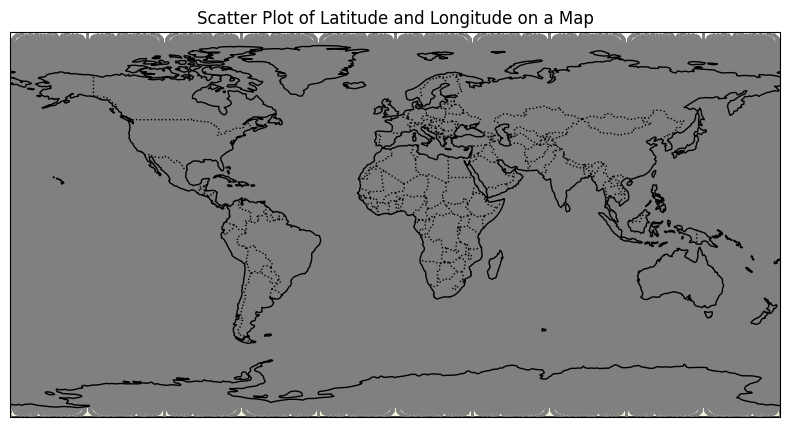

In [5]:
import eccodes
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_lat_lon(lat_file, lon_file):
    """Plots latitude and longitude points from GRIB files on a map."""
    def extract_values(grib_file):
        with open(grib_file, 'rb') as f:
            gid = eccodes.codes_grib_new_from_file(f)
            values = eccodes.codes_get_array(gid, "values")
            eccodes.codes_release(gid)
        return values
    
    latitudes = extract_values(lat_file)
    longitudes = extract_values(lon_file)
    
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.scatter(longitudes, latitudes, s=0.5, color='gray', transform=ccrs.PlateCarree())
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Scatter Plot of Latitude and Longitude on a Map")
    plt.grid()
    plt.savefig("icon_points_global.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
plot_lat_lon("icon_lat.grib", "icon_lon.grib")


In [13]:
import os
import socket

PROXY_HOST = "ofsquid.dwd.de"
PROXY_PORT = 8080

def proxy_available(host, port, timeout=1.0):
    try:
        with socket.create_connection((host, port), timeout=timeout):
            return True
    except OSError:
        return False

if proxy_available(PROXY_HOST, PROXY_PORT):
    os.environ["HTTP_PROXY"]  = f"http://{PROXY_HOST}:{PROXY_PORT}"
    os.environ["HTTPS_PROXY"] = f"http://{PROXY_HOST}:{PROXY_PORT}"
    print("Proxy enabled")
else:
    print("Proxy not reachable — running without proxy")

Proxy enabled


/Users/rpotthas/ropy/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/rpotthas/ropy/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/rpotthas/ropy/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


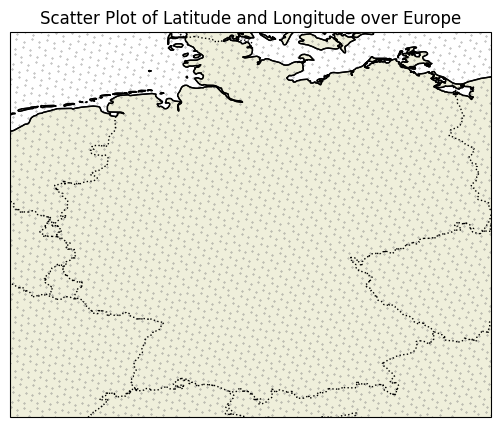

In [7]:
import eccodes
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_lat_lon_europe(lat_file, lon_file):
    """Plots latitude and longitude points from GRIB files, zoomed in over Europe."""
    def extract_values(grib_file):
        with open(grib_file, 'rb') as f:
            gid = eccodes.codes_grib_new_from_file(f)
            values = eccodes.codes_get_array(gid, "values")
            eccodes.codes_release(gid)
        return values
    
    latitudes = extract_values(lat_file)
    longitudes = extract_values(lon_file)
    
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([5, 15, 47, 55], crs=ccrs.PlateCarree())  # Europe zoom: [lon_min, lon_max, lat_min, lat_max]
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.scatter(longitudes, latitudes, s=0.1, color='gray', transform=ccrs.PlateCarree())
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Scatter Plot of Latitude and Longitude over Europe")
    plt.grid()
    plt.savefig("icon_points_germany.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
plot_lat_lon_europe("icon_lat.grib", "icon_lon.grib")

In [8]:
import datetime
import os
import wget
import bz2
import shutil

# Get timezone-aware UTC time
now = datetime.datetime.now(datetime.UTC)

# Construct the filename
filename = f"icon_global_icosahedral_single-level_{now:%Y%m%d}00_000_T_2M.grib2.bz2"
print("Constructed filename:", filename)

# Define the full download URL
base_url = "https://opendata.dwd.de/weather/nwp/icon/grib/00/t_2m/"
url = base_url + filename
print("Download URL:", url)

# Download using Python wget
print("Downloading file...")
wget.download(url, filename)
print(f"\nDownloaded: {filename}")

# Decompress .bz2 file
print("Decompressing...")
with bz2.open(filename, 'rb') as f_in:
    with open(filename[:-4], 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Final filename
grib_filename = filename[:-4]
print("Uncompressed GRIB filename:", grib_filename)

Constructed filename: icon_global_icosahedral_single-level_2025122600_000_T_2M.grib2.bz2
Download URL: https://opendata.dwd.de/weather/nwp/icon/grib/00/t_2m/icon_global_icosahedral_single-level_2025122600_000_T_2M.grib2.bz2
100% [..........................................................................] 3953776 / 3953776
Downloaded: icon_global_icosahedral_single-level_2025122600_000_T_2M.grib2.bz2
Decompressing...
Uncompressed GRIB filename: icon_global_icosahedral_single-level_2025122600_000_T_2M.grib2


In [9]:
show_shortnames("icon_t2m.grib")

--------------------------------------------------------------------------------
File =  icon_t2m.grib

Short Name                    Level                 Size
--------------------------------------------------------------------------------

2t                            2                  2949120


In [10]:
import eccodes

def load_t2m(grib_file):
    """Loads the 2-meter temperature (t2) field from a GRIB file."""
    with open(grib_file, 'rb') as f:
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            short_name = eccodes.codes_get(gid, "shortName")
            if short_name == "2t":
                values = eccodes.codes_get_array(gid, "values")
                eccodes.codes_release(gid)
                return values
            eccodes.codes_release(gid)
    return None  # Return None if t2 field is not found

# Example usage
t2m_values = load_t2m("icon_t2m.grib")
print(f"Loaded {len(t2m_values)} temperature values")

Loaded 2949120 temperature values


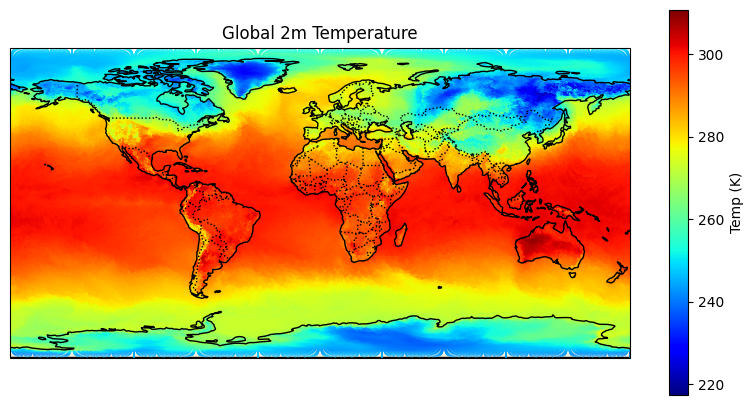

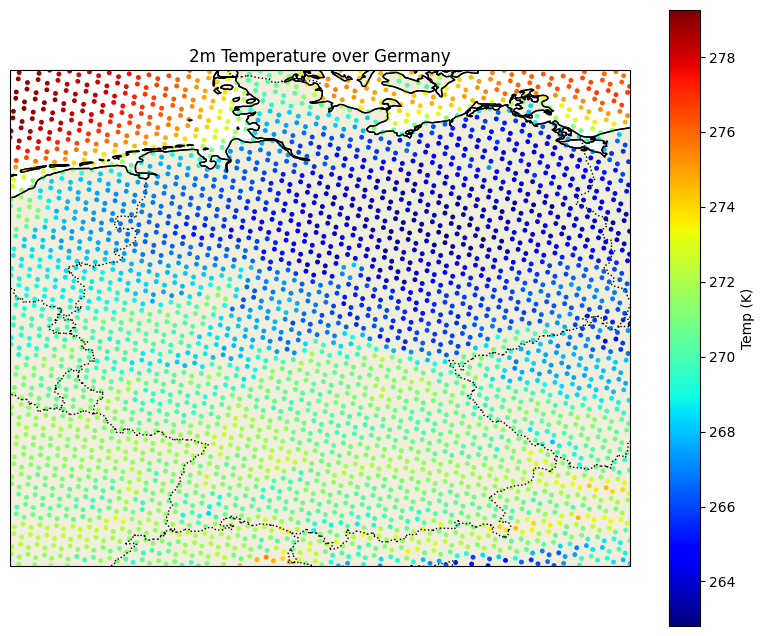

In [11]:
import eccodes
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def load_grib(file, var):
    """Loads specified variable from GRIB file."""
    with open(file, 'rb') as f:
        while (gid := eccodes.codes_grib_new_from_file(f)) is not None:
            if eccodes.codes_get(gid, "shortName") == var:
                vals = eccodes.codes_get_array(gid, "values")
                eccodes.codes_release(gid)
                return vals
            eccodes.codes_release(gid)
    return None

def plot_t2m(lat, lon, t2m, bbox, title, fname):
    """Plots 2m temperature within bbox = (latmin, latmax, lonmin, lonmax)."""
    latmin, latmax, lonmin, lonmax = bbox
    mask = (lat >= latmin) & (lat <= latmax) & (lon >= lonmin) & (lon <= lonmax)

    # Adjust aspect ratio based on bounding box
    lon_range = lonmax - lonmin
    lat_range = latmax - latmin
    aspect_ratio = lon_range / lat_range
    figsize = (10, max(5, 10 / aspect_ratio))  # Maintain consistent width & prevent extreme height

    # Adaptive point size based on bounding box area
    area = lat_range * lon_range
    point_size = max(0.05, min(10, 500 / area))  # Ensures reasonable point size

    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    plt.scatter(lon[mask], lat[mask], c=t2m[mask], cmap='jet', s=point_size, transform=ccrs.PlateCarree())
    plt.colorbar(label="Temp (K)")
    plt.title(title)
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()
    
# Load data
lat = load_grib("icon_lat.grib", "tlat")
lon = load_grib("icon_lon.grib", "tlon")
t2m = load_grib("icon_t2m.grib", "2t")

# Plot global and Germany views
plot_t2m(lat, lon, t2m, (-90, 90, -180, 180), "Global 2m Temperature", "icon_t2m_global.png")
plot_t2m(lat, lon, t2m, (47, 55, 5, 15), "2m Temperature over Germany", "icon_t2m_germany.png")

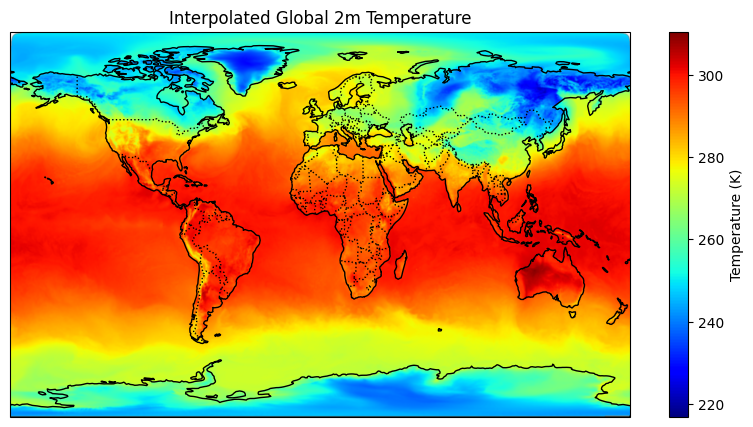

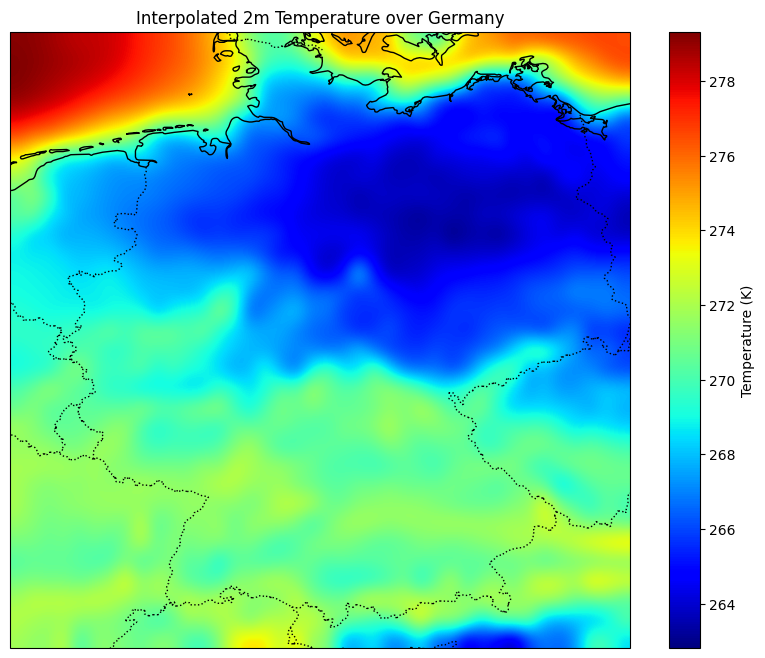

In [12]:
import eccodes
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata

def load_grib(file, var):
    """Loads specified variable from GRIB file."""
    with open(file, 'rb') as f:
        while (gid := eccodes.codes_grib_new_from_file(f)) is not None:
            if eccodes.codes_get(gid, "shortName") == var:
                vals = eccodes.codes_get_array(gid, "values")
                eccodes.codes_release(gid)
                return vals
            eccodes.codes_release(gid)
    return None

def interpolate_to_grid(lat, lon, t2m, bbox, grid_res=0.25):
    """Interpolates T2M data onto a regular lat/lon grid."""
    latmin, latmax, lonmin, lonmax = bbox

    # Define a smooth regular grid
    grid_lat = np.arange(latmin, latmax, grid_res)
    grid_lon = np.arange(lonmin, lonmax, grid_res)
    lon_grid, lat_grid = np.meshgrid(grid_lon, grid_lat)

    # Use cubic interpolation for smooth output
    t2m_grid = griddata((lon, lat), t2m, (lon_grid, lat_grid), method='cubic')

    return lon_grid, lat_grid, t2m_grid


def plot_t2m_grid(lat, lon, t2m, bbox, title, fname):
    """Plots interpolated 2m temperature as a smooth heatmap."""
    lon_grid, lat_grid, t2m_grid = interpolate_to_grid(lat, lon, t2m, bbox)

    # Set reasonable aspect ratio based on bounding box size
    lon_range = bbox[3] - bbox[2]
    lat_range = bbox[1] - bbox[0]
    aspect_ratio = lon_range / lat_range
    figsize = (10, max(5, 10 / aspect_ratio))  # Maintain consistent width & prevent extreme height

    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([bbox[2], bbox[3], bbox[0], bbox[1]])
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Use smooth interpolation and correct aspect ratio
    img = ax.imshow(t2m_grid, extent=[bbox[2], bbox[3], bbox[0], bbox[1]], origin='lower',
                    cmap='jet', transform=ccrs.PlateCarree(), aspect='auto', interpolation='bicubic')

    plt.colorbar(img, label="Temperature (K)")
    plt.title(title)
    plt.savefig(fname, dpi=200, bbox_inches='tight')  # Reduce DPI for smaller file size
    plt.show()

    
# Load data
lat = load_grib("icon_lat.grib", "tlat")
lon = load_grib("icon_lon.grib", "tlon")
t2m = load_grib("icon_t2m.grib", "2t")

# Plot interpolated global and Germany views
plot_t2m_grid(lat, lon, t2m, (-90, 90, -180, 180), "Interpolated Global 2m Temperature", "icon_t2m_global_interp.png")
plot_t2m_grid(lat, lon, t2m, (47, 55, 5, 15), "Interpolated 2m Temperature over Germany", "icon_t2m_germany_interp.png")